## Prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os , sys
from pathlib import Path
cur_path = Path(os.getcwd()).parent.parent
sys.path.append(cur_path.as_posix())
from matplotlib import pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import seaborn as sns # Seaborn is not strictly necessary, but it makes the plots look nicer (:
sns.set_theme(style='white')
%config InlineBackend.figure_format = 'retina'


### YOLO OCTRON 

In [3]:
# To access any prediction results programmatically, you can use the YOLO_results class.
import numpy as np 
import torch
from octron import YOLO_octron
from octron.sam2_octron.helpers.video_loader import probe_video  
from napari_pyav._reader import FastVideoReader              


In [4]:
video_path = Path('/Users/horst/Library/CloudStorage/GoogleDrive-hobenhaus@gmail.com/My Drive/OCTRON/Project folders - finished/bandensis_new/test/single/94e694a8442f76ba_segment_35.40s-47.41s.mp4')

In [5]:
# probe video metadata & store reader
vdict = {}
meta = probe_video(video_path)
reader = FastVideoReader(video_path, read_format='rgb24')
vdict[video_path.name] = {**meta, 'video': reader}

File: 94e694a8442f76ba_segment_35.40s-47.41s.mp4
Codec: h264
Resolution: 2064 x 1544
Frame Rate: 20.00 fps
Number of frames: 240
Duration: 12.00 seconds


In [6]:
yolo_octron = YOLO_octron()

No models YAML path provided. Model dictionary will be empty.


In [7]:
model_path = '/Users/horst/Library/CloudStorage/GoogleDrive-hobenhaus@gmail.com/My Drive/OCTRON/Project folders - finished/bandensis_new/model L 1024/training/weights/best.pt'
model_args = yolo_octron.load_model_args(model_name_path=model_path)
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: mps


In [8]:
for result in yolo_octron.predict_batch(
    videos_dict=vdict,
    model_path=model_path,
    device=device,
    tracker_name='ByteTrack',
    skip_frames=20,
    one_object_per_label=True,
    iou_thresh=.4,
    conf_thresh=.6,
    opening_radius=2,
    overwrite=True, 
):
    if 'save_dir' in result: 
        save_dir = result['save_dir']
    

Model args loaded from /Users/horst/Library/CloudStorage/GoogleDrive-hobenhaus@gmail.com/My Drive/OCTRON/Project folders - finished/bandensis_new/model L 1024/training
Image size: 1024
⚠ Tracking only one object per label.
Model loaded from '/Users/horst/Library/CloudStorage/GoogleDrive-hobenhaus@gmail.com/My Drive/OCTRON/Project folders - finished/bandensis_new/model L 1024/training/weights/best.pt'

Processing video 1/1: 94e694a8442f76ba_segment_35.40s-47.41s.mp4
ByteTrack configuration written to /Users/horst/Library/CloudStorage/GoogleDrive-hobenhaus@gmail.com/My Drive/OCTRON/Project folders - finished/bandensis_new/test/single/predictions/94e694a8442f76ba_segment_35.40s-47.41s_bytetrack/bytetrack.yaml
Saved tracking data for 'stone' (track ID: 1) to stone_track_1.csv
Saved tracking data for 'mantle' (track ID: 2) to mantle_track_2.csv
Saved tracking data for 'head' (track ID: 3) to head_track_3.csv
Saved prediction metadata to /Users/horst/Library/CloudStorage/GoogleDrive-hobenhau

In [9]:
if hasattr(model_args, 'stride'):
    print(f"Model stride: {model_args.stride}")

In [10]:
# Load results 
from octron import YOLO_results
yolo_results = YOLO_results(save_dir)

File: 94e694a8442f76ba_segment_35.40s-47.41s.mp4
Codec: h264
Resolution: 2064 x 1544
Frame Rate: 20.00 fps
Number of frames: 240
Duration: 12.00 seconds
Found 3 tracking CSV files in '94e694a8442f76ba_segment_35.40s-47.41s_bytetrack'
Found tracking zarr in '94e694a8442f76ba_segment_35.40s-47.41s_bytetrack'
Existing keys in zarr archive: ['1_masks', '2_masks', '3_masks']
Found 3 unique track IDs in zarr and CSVs: {1: 'stone', 2: 'mantle', 3: 'head'}


In [11]:
mask_data = yolo_results.get_mask_data()
mask_data.keys()

dict_keys([1, 2, 3])

In [12]:
yolo_results.track_id_label

{1: 'stone', 2: 'mantle', 3: 'head'}

In [13]:
# Load example
masks, frame_indices = mask_data[1]['data'], mask_data[1]['frame_indices']

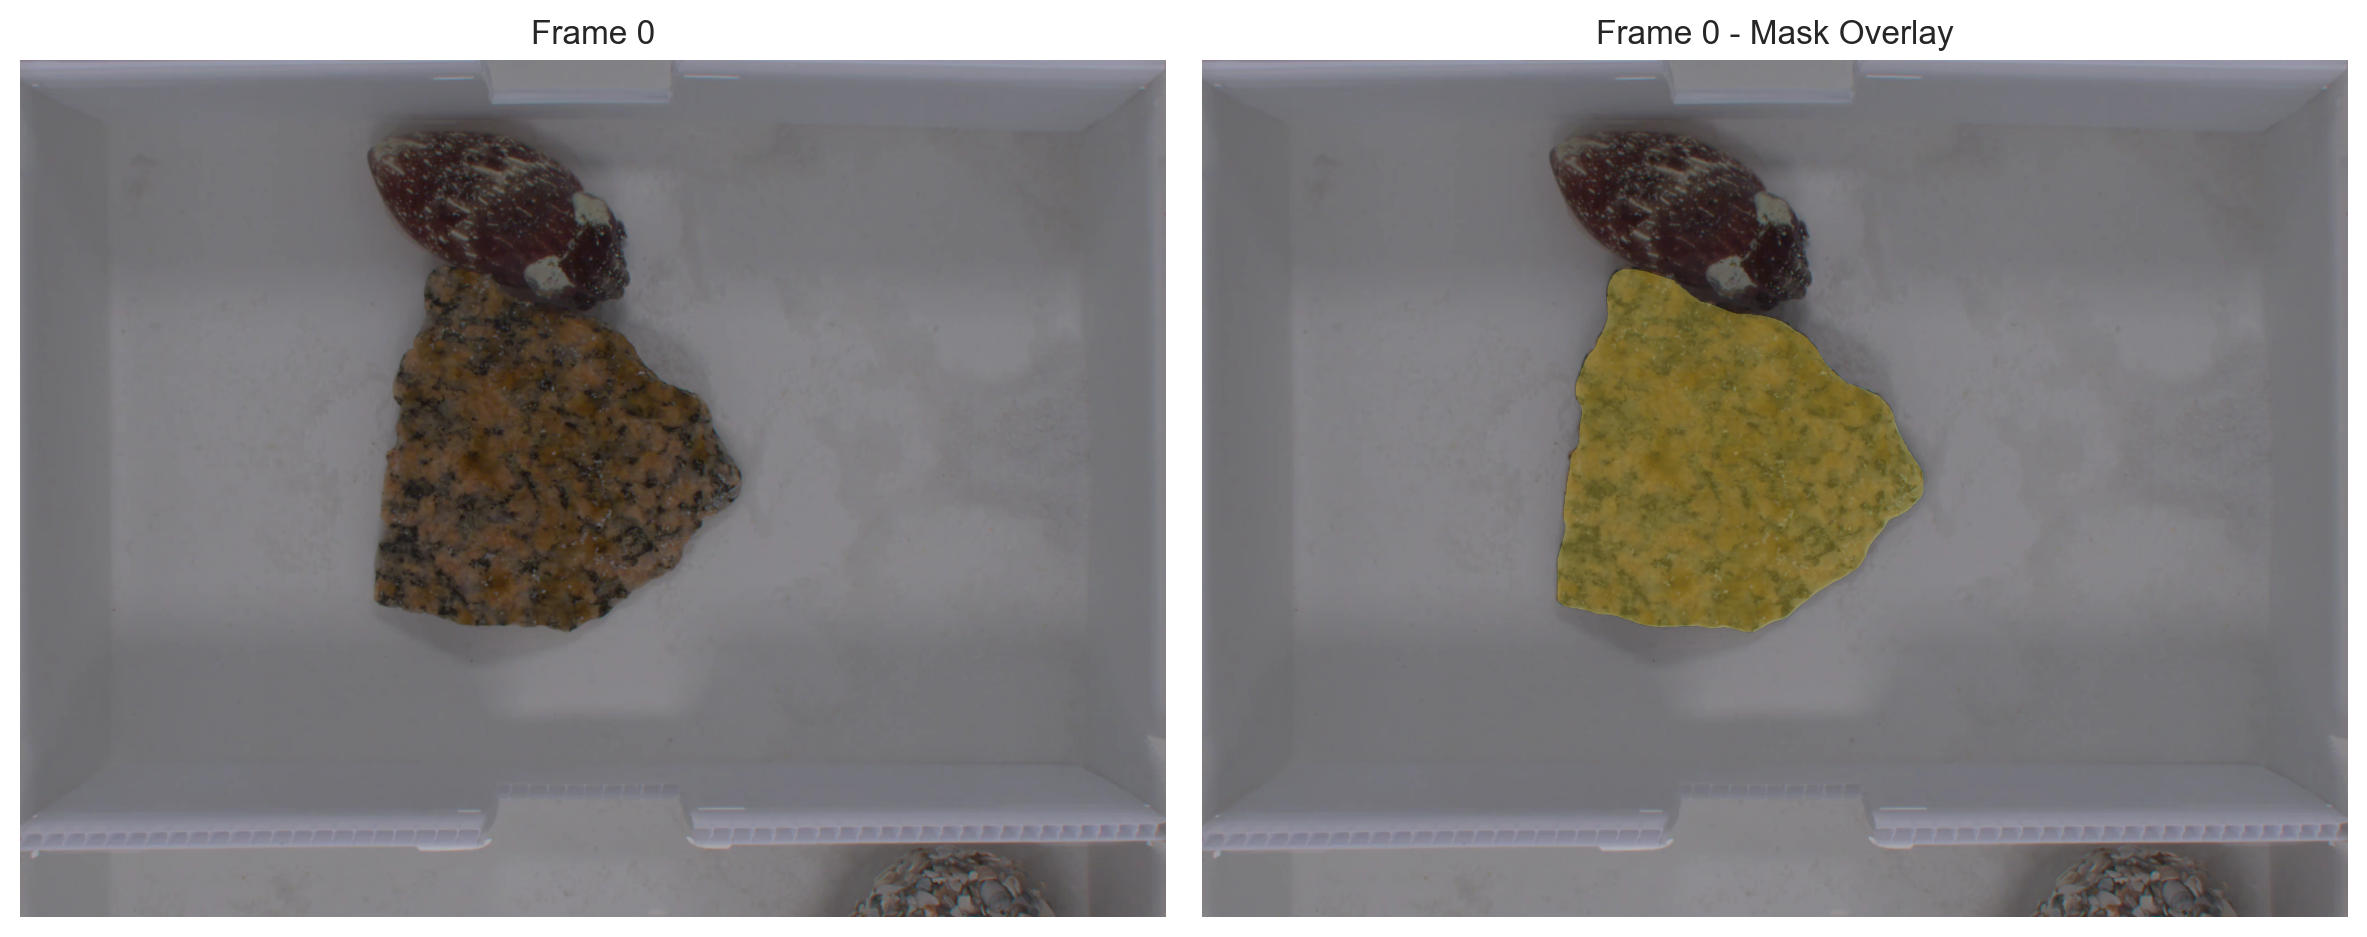

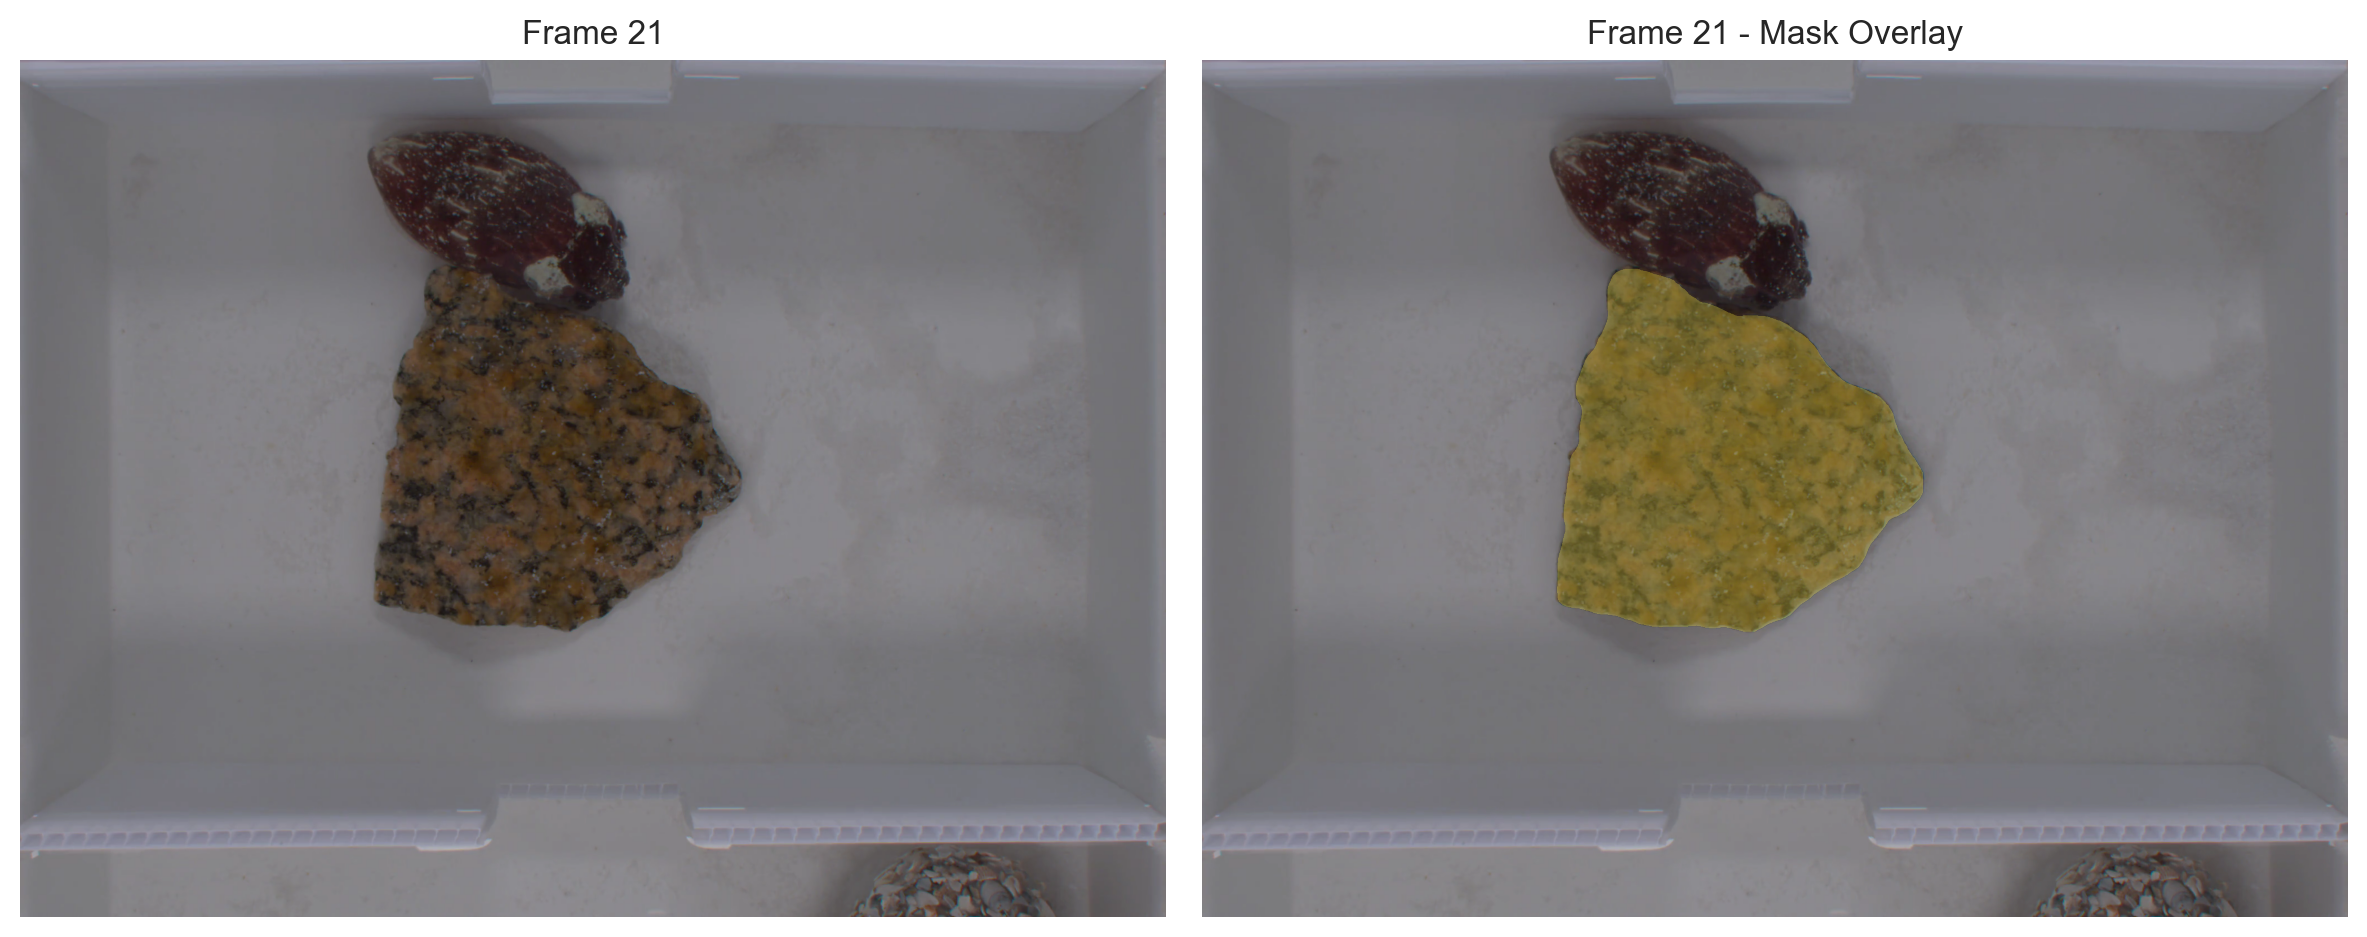

In [15]:
for f in frame_indices:
    mask = masks[f]  # mask is a boolean numpy array
    frame = reader[f] # frame is an RGB numpy array
    
    plt.figure(figsize=(12, 6)) # Adjusted figsize for two side-by-side plots

    # Subplot 1: Original Frame
    plt.subplot(1, 2, 1)
    plt.imshow(frame)
    plt.title(f"Frame {f}")
    plt.axis('off')

    # Subplot 2: Frame with Mask Overlay
    plt.subplot(1, 2, 2)
    # Display the original frame at full opacity
    plt.imshow(frame)
    
    # Create an RGBA overlay for the mask
    mask_true_color_rgba = cmr.ember(1.0) 
    overlay_rgba = np.zeros((*mask.shape, 4), dtype=float)
    
    # Where the mask is True:
    # Set the RGB channels from mask_true_color_rgba
    mask_bool = mask.astype(bool)
    overlay_rgba[mask_bool, 0] = mask_true_color_rgba[0]
    overlay_rgba[mask_bool, 1] = mask_true_color_rgba[1]
    overlay_rgba[mask_bool, 2] = mask_true_color_rgba[2]
    overlay_rgba[mask_bool, 3] = 0.3 # Adjust alpha value (0.0 to 1.0) as needed
    
    # Display the semi-transparent colored mask on top of the frame
    plt.imshow(overlay_rgba)
    
    plt.title(f"Frame {f} - Mask Overlay")
    plt.axis('off')
    
    plt.tight_layout() # Adjust layout to prevent titles/labels overlapping
    plt.show()
    if f > 20: 
        break